## Objective:
- The objective from this project is to create a <b>Logistic Regression Classifier</b> to predict the <b>Stroke Condition</b>.
- <b>Stoke</b> is a condition in which either the blood flow to the brain stops or blood flow is excessive.
- It is required to obtain <b>ROC > 0.65</b>.

### Data:
- Data is provided in csv format in a file named <b>healthcare-dataset-stroke-data.csv</b>

### Column names and data types are as follow:
- id, integer.
- gender, string.
- age, double.
- hypertension, integer.
- heart_disease, integer.
- ever_married, string.
- work_type, string.
- Residence_type, string.
- avg_glucose_level, double.
- bmi, double.
- smoking_status, string.
- stroke, integer <b>(Target Label)</b>.
If the person has stroke the stroke label value is <b>"1"</b> otherwise <b>"0"</b>.

### Create a spark session and import the required libraries

In [ ]:
!pip install pyspark 

In [ ]:
# importing libraries
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [ ]:
spark = SparkSession.builder.appName("Spark Exam").getOrCreate()

### Create a data schema programatically

In [ ]:
schema = "id INT,gender STRING, age Double,hypertension INT ,heart_disease INT ,ever_married STRING, work_type STRING,Residence_type STRING,avg_glucose_level Double,bmi Double,smoking_status STRING,stroke INT"



- Provide the schema and any other required options.

In [ ]:
df=(spark.read.format('csv')
    .schema(schema)
    .option('header','true')
    .load("/content/healthcare_dataset_stroke_data.csv"))

### Explore the data 
#### You have to do the following:
- Print the Schema.
- Show the first 10 rows from the data.
- Explore null values and show how many null values in each column.
- Plot a count plot for the target label and <b>notice the graph</b>.
- Perform any additional EDA you find useful.

In [ ]:
df.printSchema()
df.show(10)

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|  

In [ ]:
from pyspark.sql.functions import col,isnan,when,count
df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|201|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [ ]:
pandasDF = df.toPandas()
print(pandasDF)

         id  gender   age  ...   bmi   smoking_status stroke
0      9046    Male  67.0  ...  36.6  formerly smoked      1
1     51676  Female  61.0  ...   NaN     never smoked      1
2     31112    Male  80.0  ...  32.5     never smoked      1
3     60182  Female  49.0  ...  34.4           smokes      1
4      1665  Female  79.0  ...  24.0     never smoked      1
...     ...     ...   ...  ...   ...              ...    ...
5105  18234  Female  80.0  ...   NaN     never smoked      0
5106  44873  Female  81.0  ...  40.0     never smoked      0
5107  19723  Female  35.0  ...  30.6     never smoked      0
5108  37544    Male  51.0  ...  25.6  formerly smoked      0
5109  44679  Female  44.0  ...  26.2          Unknown      0

[5110 rows x 12 columns]


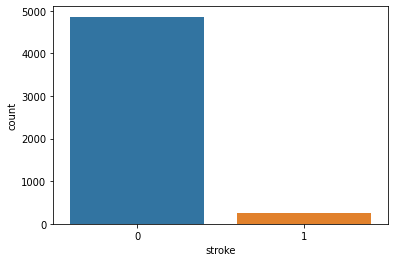

In [ ]:
import seaborn as sns
sns.countplot(x="stroke",data=pandasDF)

### Get the summary statistics of the age column
- You will find the minimum age is about <b>0.08</b>.
- Remove rows for the age below <b>2 years old</b>.

In [ ]:
df.describe(['age']).show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              5110|
|   mean|43.226614481409015|
| stddev| 22.61264672311348|
|    min|              0.08|
|    max|              82.0|
+-------+------------------+



In [ ]:
df = df.filter(df.age > 2)
df.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|null|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

### Working with gender & smoking_status columns:
- Select and show the gender & smoking_status columns
- Get the distinct values for each column.

In [ ]:
df.select(df.gender,df.smoking_status).show()

+------+---------------+
|gender| smoking_status|
+------+---------------+
|  Male|formerly smoked|
|Female|   never smoked|
|  Male|   never smoked|
|Female|         smokes|
|Female|   never smoked|
|  Male|formerly smoked|
|  Male|   never smoked|
|Female|   never smoked|
|Female|        Unknown|
|Female|        Unknown|
|Female|   never smoked|
|Female|         smokes|
|Female|         smokes|
|  Male|        Unknown|
|Female|   never smoked|
|Female|   never smoked|
|  Male|         smokes|
|  Male|         smokes|
|Female|   never smoked|
|  Male|        Unknown|
+------+---------------+
only showing top 20 rows



In [ ]:
df.select(df.gender).distinct().show()

+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+



In [ ]:
df.select(df.smoking_status).distinct().show()

+---------------+
| smoking_status|
+---------------+
|         smokes|
|        Unknown|
|   never smoked|
|formerly smoked|
+---------------+



#### Change the string values of the columns into numerical values as follow:
1. Gender column:
    * Male = 1 
    * Female = 0 
    * Other = 0 
2. Smoking Status column:
  * never smoked = 0
  * Unknown = 0.5
  * formerly smoked = 0.75
  * smokes = 1.0


In [ ]:
df=df.withColumn("gender",
                     when(col("gender")=='Male', 1)
                     .when(col("gender")=='Female', 0)
                     .otherwise(0))

df=df.withColumn("smoking_status",when(col("smoking_status")=='never smoked', 0)
                     .when(col("smoking_status")=='Unknown', 0.5)
                     .when(col("smoking_status")=='formerly smoked', 0.75)
                     .when(col("smoking_status")=='smokes', 1))
df.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+--------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+--------------+------+
| 9046|     1|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|          0.75|     1|
|51676|     0|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|null|           0.0|     1|
|31112|     1|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|           0.0|     1|
|60182|     0|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|           1.0|     1|
| 1665|     0|79.0|           1|            0|         Yes|Sel

#### Show the output DataFrame
- Select and show the gender & smoking_status columns after value changing.
- Print schema for the new dataframe.

In [ ]:
df.select(df.gender,df.smoking_status).show()

+------+--------------+
|gender|smoking_status|
+------+--------------+
|     1|          0.75|
|     0|           0.0|
|     1|           0.0|
|     0|           1.0|
|     0|           0.0|
|     1|          0.75|
|     1|           0.0|
|     0|           0.0|
|     0|           0.5|
|     0|           0.5|
|     0|           0.0|
|     0|           1.0|
|     0|           1.0|
|     1|           0.5|
|     0|           0.0|
|     0|           0.0|
|     1|           1.0|
|     1|           1.0|
|     0|           0.0|
|     1|           0.5|
+------+--------------+
only showing top 20 rows



### Deal with null value according to your data analysis.

In [ ]:
from pyspark.sql.functions import mean,round
mean_val = df.select(mean(df['bmi'])).collect()
mean_bmi =int( mean_val[0][0])
mean_bmi

29

In [ ]:

df=df.na.fill(mean_bmi,subset=['bmi'])
df.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+------------------+--------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|               bmi|smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+------------------+--------------+------+
| 9046|     1|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|              36.6|          0.75|     1|
|51676|     0|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|29.257489451476793|           0.0|     1|
|31112|     1|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|              32.5|           0.0|     1|
|60182|     0|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|      

### Split the data into training and test dataframes:
- 80% training and 20% test.
- seed = 42.
- Save each dataframe as a parquet file

In [ ]:
trainDF, testDF = df.randomSplit([.8,.2],seed=42)
print(f"There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set")

There are 3991 rows in the training set, and 944 in the test set


In [ ]:
trainDF.write.parquet("train.parquet")
testDF.write.parquet("test.parquet")

AnalysisException: ignored

### Read the saved Train and Test DataFrame:
- Use the dataframes you read in the subsequent steps.

In [ ]:
train = spark.read.format('parquet').load('train.parquet')
test = spark.read.format('parquet').load('test.parquet')


### Create the model:
- Perform feature engineering steps.
- Create the logistic regression classifier.
- Build the pipeline model that uses all feature engineering steps and the model.
- Train the pipeline model using the trainig dataset.

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler,OneHotEncoder
from pyspark.ml import Pipeline

In [ ]:
categoricalCols = [field for (field, dataType) in train.dtypes
                   if dataType == "string"]
categoricalCols

['ever_married', 'work_type', 'Residence_type']

In [ ]:
indexOutputCols = [x + "_Index" for x in categoricalCols]
indexOutputCols
oheOutputCols = [x + "_OHE" for x in categoricalCols]
oheOutputCols

['ever_married_OHE', 'work_type_OHE', 'Residence_type_OHE']

In [ ]:
stringIndexer = StringIndexer(inputCols=categoricalCols,
                             outputCols=indexOutputCols,
                             handleInvalid='skip')
oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                          outputCols=oheOutputCols)

In [ ]:
numericCols = [field for (field,dataType) in train.dtypes
              if ((dataType=='double') | (dataType=='INT') & (field!='stroke') &(field!='stroke'))]
numericCols

['age', 'avg_glucose_level', 'bmi', 'smoking_status']

In [ ]:
assemblerInputs = oheOutputCols + numericCols
assemblerInputs

['ever_married_OHE',
 'work_type_OHE',
 'Residence_type_OHE',
 'age',
 'avg_glucose_level',
 'bmi',
 'smoking_status']

In [ ]:
vecAssembler = VectorAssembler(inputCols=numericCols,outputCol='features')

In [ ]:
from pyspark.ml.classification import LogisticRegression
model = LogisticRegression(labelCol='stroke',featuresCol='features')
pipeline = Pipeline(stages=[stringIndexer,oheEncoder,vecAssembler,model])
pipeline_Model = pipeline.fit(train)

### Perform predictions on tests dataframe:
- Test the model using the test dataframe
- Select and show the feature column.
- Print the schema of the output dataframe.
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   

In [ ]:
predictions = pipeline_Model.transform(test)
predictions.select('features').show(truncate=False)

+-------------------------------------+
|features                             |
+-------------------------------------+
|[55.0,89.17,31.5,0.0]                |
|[24.0,97.55,26.2,0.0]                |
|[33.0,86.97,42.2,0.0]                |
|[43.0,88.23,37.6,0.5]                |
|[79.0,198.79,24.9,0.0]               |
|[43.0,110.32,28.4,0.0]               |
|[78.0,75.19,27.6,0.0]                |
|[74.0,74.96,26.6,0.0]                |
|[14.0,92.22,22.8,0.5]                |
|[69.0,101.52,26.8,1.0]               |
|[52.0,87.26,40.1,1.0]                |
|[82.0,84.03,26.5,0.75]               |
|[17.0,81.77,44.7,0.0]                |
|[73.0,79.69,29.257489451476793,0.75] |
|[59.0,99.06,23.4,0.0]                |
|[60.0,80.86,31.0,1.0]                |
|[14.0,83.42,28.7,0.0]                |
|[69.0,229.21,30.1,1.0]               |
|[70.0,202.55,29.257489451476793,0.75]|
|[29.0,71.89,27.6,0.0]                |
+-------------------------------------+
only showing top 20 rows



In [ ]:
predictions.printSchema()


root
 |-- id: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: double (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- ever_married_Index: double (nullable = false)
 |-- work_type_Index: double (nullable = false)
 |-- Residence_type_Index: double (nullable = false)
 |-- ever_married_OHE: vector (nullable = true)
 |-- work_type_OHE: vector (nullable = true)
 |-- Residence_type_OHE: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [ ]:
predictions.select('stroke','prediction').show()

+------+----------+
|stroke|prediction|
+------+----------+
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
+------+----------+
only showing top 20 rows



In [ ]:
predictions.select('stroke','prediction').filter(predictions.stroke==1).show()  

+------+----------+
|stroke|prediction|
+------+----------+
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
+------+----------+
only showing top 20 rows



In [ ]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  944|
+----------+-----+



### Evaluate the model performance
- Use <b>BinaryClassificationEvaluator</b>. This will calculate the <b>ROC</b>.
- Set the parameters as follow:
    - <b>rawPredictionCol='prediction'</b> and <b>labelCol='stroke'</b>

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
evaluatorROC = BinaryClassificationEvaluator(rawPredictionCol='prediction'
                                             ,labelCol='stroke')

In [ ]:
evaluatorROC.evaluate(predictions)

0.5

### Improve Model Performance
- You may noticed that <b>the target label is imbalanced</b>.
- LogisticRegression classifier has a special parameter <b>weightCol</b> to deal with imbalanced class.
- In order to use this parameter you must have a <b>weightCol</b> in your training dataframe.
- In order to create this column you will need to define a <b>UDF</b> and apply it to the target label column.
- Create a LogisticRegression classifier with <b>weightCol</b> parameter.
- Build and train a pipeline model with the new LogisticRegression.
- Perform the prediction on the test dataframe. 
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   
- Evaluate the model performance exactly as in the previous step.
### YOU SHOULD OBTAIN  ROC > 0.65
<BR>
<b><font color='red'>Note: feel free to deal with the imbalanced cluster with the above method or another. However, you can only use methods applied on SPARK DATAFRAME</font></b>

In [ ]:
ratio=0.95
def weight_balance(labels):
    return when(labels == 1, ratio).otherwise(1*(1-ratio))
Modify_train= train.withColumn('weights', weight_balance(col('stroke')))
model = LogisticRegression(labelCol='stroke',featuresCol='features',weightCol='weights')
pipeline = Pipeline(stages=[stringIndexer,oheEncoder,vecAssembler,model])
pipeline_Model = pipeline.fit(Modify_train)
Modify_predictions = pipeline_Model.transform(test)

In [ ]:
predictions_last.select('stroke','prediction').show()

+------+----------+
|stroke|prediction|
+------+----------+
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       1.0|
|     0|       0.0|
|     0|       1.0|
|     1|       1.0|
|     0|       0.0|
|     0|       1.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     0|       1.0|
|     0|       0.0|
|     0|       1.0|
|     0|       0.0|
|     0|       1.0|
|     0|       1.0|
|     0|       0.0|
+------+----------+
only showing top 20 rows



In [ ]:
predictions_last.select('stroke','prediction').filter(predictions_last.stroke==1).show()  

+------+----------+
|stroke|prediction|
+------+----------+
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       0.0|
|     1|       1.0|
|     1|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       0.0|
|     1|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
+------+----------+
only showing top 20 rows



In [ ]:
predictions_last.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  673|
|       1.0|  271|
+----------+-----+



In [ ]:
evaluatorROC.evaluate(predictions_last)

0.7514662133446665